In [334]:
import imblearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from imblearn.pipeline import make_pipeline as imb_pipline
from sklearn.naive_bayes import GaussianNB, BernoulliNB, CategoricalNB, MultinomialNB
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_val_predict
from sklearn.metrics import f1_score, precision_score, recall_score, mean_squared_error, r2_score
from sklearn import svm, tree
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import fbeta_score, make_scorer
from math import sqrt
import seaborn as sns
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import NearMiss

sns.set()

In [335]:
data = pd.read_csv('../p_train.csv')
target = pd.read_csv('../PerStatus.csv')
data.drop(['Work Overtime'], inplace=True, axis=1)

In [336]:
test = pd.read_csv('../E_data/stest.csv')
test.drop(['Unnamed: 0', 'PerStatus', 'PerNo', 'Work Overtime'], axis=1, inplace=True)
test.columns = data.columns
test.ffill(inplace=True)
test.fillna(0, inplace=True)

In [337]:
full = data.append(test, ignore_index=True)

In [338]:
X_train, X_test, Y_train, Y_test = train_test_split(data, target, test_size=0.25)

In [339]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer

categorical_columns = full.columns
categorical_pipeline = make_pipeline(
    SimpleImputer(missing_values=-1, strategy='most_frequent'),
    OneHotEncoder(categories='auto'))

preprocessor = ColumnTransformer(
    [('categorical_preprocessing', categorical_pipeline, categorical_columns)],
    remainder='drop')

In [340]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall

def build_model(n_features):
    model = Sequential()
    model.add(Dense(100, input_shape=(n_features,),
              kernel_initializer='glorot_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, kernel_initializer='glorot_normal', use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', Recall(name='recall')])

    return model

In [341]:
from sklearn.metrics import roc_auc_score
from imblearn.keras import BalancedBatchGenerator

def fit_predict_balanced_model(X_train, Y_train, X_test, Y_test):
    model = build_model(X_train.shape[1])
    training_generator = BalancedBatchGenerator(X_train, Y_train,
                                                batch_size=100,
                                                random_state=42)
    model.fit_generator(generator=training_generator, epochs=50, verbose=1)
    y_pred = model.predict_proba(X_test, batch_size=300)
    return roc_auc_score(Y_test, y_pred), model

In [342]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10)
full = preprocessor.fit_transform(full)
models = []

cv_results_balanced = []
for train_idx, valid_idx in skf.split(X_train, Y_train):
    X_local_train = preprocessor.transform(X_train.iloc[train_idx])
    y_local_train = Y_train.iloc[train_idx].values.ravel()
    X_local_test = preprocessor.transform(X_train.iloc[valid_idx])
    y_local_test = Y_train.iloc[valid_idx].values.ravel()

    roc_auc, model = fit_predict_balanced_model(
        X_local_train, y_local_train, X_local_test, y_local_test)
    models.append(model)
    cv_results_balanced.append(roc_auc)

Epoch 1/50
10/10 [==============================] - 0s 2ms/step - loss: 0.8257 - accuracy: 0.5160 - recall: 0.7924
Epoch 2/50
10/10 [==============================] - 0s 2ms/step - loss: 0.7445 - accuracy: 0.5500 - recall: 0.7884
Epoch 3/50
10/10 [==============================] - 0s 2ms/step - loss: 0.6907 - accuracy: 0.5770 - recall: 0.7964
Epoch 4/50
10/10 [==============================] - 0s 2ms/step - loss: 0.6602 - accuracy: 0.6080 - recall: 0.7884
Epoch 5/50
10/10 [==============================] - 0s 2ms/step - loss: 0.6256 - accuracy: 0.6440 - recall: 0.7964
Epoch 6/50
10/10 [==============================] - 0s 2ms/step - loss: 0.6203 - accuracy: 0.6440 - recall: 0.7705
Epoch 7/50
10/10 [==============================] - 0s 2ms/step - loss: 0.5911 - accuracy: 0.6690 - recall: 0.7904
Epoch 8/50
10/10 [==============================] - 0s 2ms/step - loss: 0.5748 - accuracy: 0.7000 - recall: 0.7864
Epoch 9/50
10/10 [==============================] - 0s 2ms/step - loss: 0.5496 -

10/10 [==============================] - 0s 2ms/step - loss: 0.3923 - accuracy: 0.8440 - recall: 0.8383
Epoch 22/50
10/10 [==============================] - 0s 2ms/step - loss: 0.3595 - accuracy: 0.8710 - recall: 0.8683
Epoch 23/50
10/10 [==============================] - 0s 2ms/step - loss: 0.3621 - accuracy: 0.8640 - recall: 0.8683
Epoch 24/50
10/10 [==============================] - 0s 2ms/step - loss: 0.3486 - accuracy: 0.8740 - recall: 0.8623
Epoch 25/50
10/10 [==============================] - 0s 2ms/step - loss: 0.3440 - accuracy: 0.8730 - recall: 0.8743
Epoch 26/50
10/10 [==============================] - 0s 2ms/step - loss: 0.3281 - accuracy: 0.8850 - recall: 0.8922
Epoch 27/50
10/10 [==============================] - 0s 2ms/step - loss: 0.3182 - accuracy: 0.8860 - recall: 0.8743
Epoch 28/50
10/10 [==============================] - 0s 2ms/step - loss: 0.3150 - accuracy: 0.9030 - recall: 0.9022
Epoch 29/50
10/10 [==============================] - 0s 2ms/step - loss: 0.2982 - ac

10/10 [==============================] - 0s 2ms/step - loss: 0.1797 - accuracy: 0.9560 - recall: 0.9523
Epoch 42/50
10/10 [==============================] - 0s 2ms/step - loss: 0.1710 - accuracy: 0.9530 - recall: 0.9384
Epoch 43/50
10/10 [==============================] - 0s 2ms/step - loss: 0.1658 - accuracy: 0.9630 - recall: 0.9662
Epoch 44/50
10/10 [==============================] - 0s 2ms/step - loss: 0.1590 - accuracy: 0.9610 - recall: 0.9463
Epoch 45/50
10/10 [==============================] - 0s 2ms/step - loss: 0.1558 - accuracy: 0.9620 - recall: 0.9523
Epoch 46/50
10/10 [==============================] - 0s 2ms/step - loss: 0.1524 - accuracy: 0.9630 - recall: 0.9523
Epoch 47/50
10/10 [==============================] - 0s 2ms/step - loss: 0.1423 - accuracy: 0.9660 - recall: 0.9682
Epoch 48/50
10/10 [==============================] - 0s 2ms/step - loss: 0.1389 - accuracy: 0.9600 - recall: 0.9543
Epoch 49/50
10/10 [==============================] - 0s 2ms/step - loss: 0.1258 - ac

10/10 [==============================] - 0s 2ms/step - loss: 0.5253 - accuracy: 0.7450 - recall: 0.7505
Epoch 12/50
10/10 [==============================] - 0s 2ms/step - loss: 0.4985 - accuracy: 0.7820 - recall: 0.7864
Epoch 13/50
10/10 [==============================] - 0s 2ms/step - loss: 0.4864 - accuracy: 0.7710 - recall: 0.7824
Epoch 14/50
10/10 [==============================] - 0s 2ms/step - loss: 0.4731 - accuracy: 0.8050 - recall: 0.7824
Epoch 15/50
10/10 [==============================] - 0s 2ms/step - loss: 0.4572 - accuracy: 0.8060 - recall: 0.7904
Epoch 16/50
10/10 [==============================] - 0s 2ms/step - loss: 0.4435 - accuracy: 0.8250 - recall: 0.8124
Epoch 17/50
10/10 [==============================] - 0s 2ms/step - loss: 0.4444 - accuracy: 0.8290 - recall: 0.8184
Epoch 18/50
10/10 [==============================] - 0s 2ms/step - loss: 0.4196 - accuracy: 0.8430 - recall: 0.8144
Epoch 19/50
10/10 [==============================] - 0s 2ms/step - loss: 0.4018 - ac

10/10 [==============================] - 0s 2ms/step - loss: 0.2441 - accuracy: 0.9180 - recall: 0.9261
Epoch 32/50
10/10 [==============================] - 0s 2ms/step - loss: 0.2480 - accuracy: 0.9170 - recall: 0.9301
Epoch 33/50
10/10 [==============================] - 0s 2ms/step - loss: 0.2343 - accuracy: 0.9140 - recall: 0.9202
Epoch 34/50
10/10 [==============================] - 0s 2ms/step - loss: 0.2154 - accuracy: 0.9290 - recall: 0.9281
Epoch 35/50
10/10 [==============================] - 0s 2ms/step - loss: 0.2095 - accuracy: 0.9370 - recall: 0.9481
Epoch 36/50
10/10 [==============================] - 0s 2ms/step - loss: 0.2126 - accuracy: 0.9350 - recall: 0.9381
Epoch 37/50
10/10 [==============================] - 0s 2ms/step - loss: 0.1918 - accuracy: 0.9370 - recall: 0.9341
Epoch 38/50
10/10 [==============================] - 0s 2ms/step - loss: 0.1694 - accuracy: 0.9490 - recall: 0.9501
Epoch 39/50
10/10 [==============================] - 0s 2ms/step - loss: 0.1691 - ac

10/10 [==============================] - 0s 2ms/step - loss: 0.8389 - accuracy: 0.4750 - recall: 0.1776
Epoch 2/50
10/10 [==============================] - 0s 2ms/step - loss: 0.7334 - accuracy: 0.5610 - recall: 0.2914
Epoch 3/50
10/10 [==============================] - 0s 2ms/step - loss: 0.6915 - accuracy: 0.5820 - recall: 0.3353
Epoch 4/50
10/10 [==============================] - 0s 2ms/step - loss: 0.6601 - accuracy: 0.6170 - recall: 0.3992
Epoch 5/50
10/10 [==============================] - 0s 2ms/step - loss: 0.6129 - accuracy: 0.6420 - recall: 0.4611
Epoch 6/50
10/10 [==============================] - 0s 2ms/step - loss: 0.6085 - accuracy: 0.6550 - recall: 0.5250
Epoch 7/50
10/10 [==============================] - 0s 2ms/step - loss: 0.5832 - accuracy: 0.6760 - recall: 0.5329
Epoch 8/50
10/10 [==============================] - 0s 2ms/step - loss: 0.5688 - accuracy: 0.6950 - recall: 0.5749
Epoch 9/50
10/10 [==============================] - 0s 2ms/step - loss: 0.5525 - accuracy: 

10/10 [==============================] - 0s 2ms/step - loss: 0.3685 - accuracy: 0.8430 - recall: 0.8343
Epoch 22/50
10/10 [==============================] - 0s 2ms/step - loss: 0.3568 - accuracy: 0.8600 - recall: 0.8443
Epoch 23/50
10/10 [==============================] - 0s 2ms/step - loss: 0.3598 - accuracy: 0.8670 - recall: 0.8463
Epoch 24/50
10/10 [==============================] - 0s 2ms/step - loss: 0.3487 - accuracy: 0.8550 - recall: 0.8343
Epoch 25/50
10/10 [==============================] - 0s 2ms/step - loss: 0.3327 - accuracy: 0.8790 - recall: 0.8383
Epoch 26/50
10/10 [==============================] - 0s 2ms/step - loss: 0.3223 - accuracy: 0.8790 - recall: 0.8583
Epoch 27/50
10/10 [==============================] - 0s 2ms/step - loss: 0.3079 - accuracy: 0.8920 - recall: 0.8762
Epoch 28/50
10/10 [==============================] - 0s 2ms/step - loss: 0.2894 - accuracy: 0.9030 - recall: 0.8962
Epoch 29/50
10/10 [==============================] - 0s 2ms/step - loss: 0.2814 - ac

10/10 [==============================] - 0s 2ms/step - loss: 0.1567 - accuracy: 0.9540 - recall: 0.9481
Epoch 42/50
10/10 [==============================] - 0s 2ms/step - loss: 0.1453 - accuracy: 0.9590 - recall: 0.9581
Epoch 43/50
10/10 [==============================] - 0s 2ms/step - loss: 0.1469 - accuracy: 0.9630 - recall: 0.9681
Epoch 44/50
10/10 [==============================] - 0s 2ms/step - loss: 0.1382 - accuracy: 0.9590 - recall: 0.9561
Epoch 45/50
10/10 [==============================] - 0s 3ms/step - loss: 0.1315 - accuracy: 0.9670 - recall: 0.9661
Epoch 46/50
10/10 [==============================] - 0s 2ms/step - loss: 0.1250 - accuracy: 0.9690 - recall: 0.9701
Epoch 47/50
10/10 [==============================] - 0s 2ms/step - loss: 0.1274 - accuracy: 0.9660 - recall: 0.9661
Epoch 48/50
10/10 [==============================] - 0s 2ms/step - loss: 0.1079 - accuracy: 0.9740 - recall: 0.9721
Epoch 49/50
10/10 [==============================] - 0s 2ms/step - loss: 0.1143 - ac

Text(0.5, 1.0, 'Difference in terms of ROC-AUC using a random under-sampling')

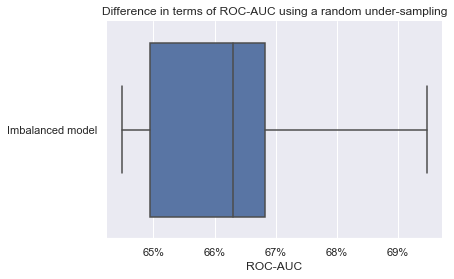

In [343]:
df_results = (pd.DataFrame({'Imbalanced model': cv_results_balanced}).unstack().reset_index())

plt.figure()
sns.boxplot(y='level_0', x=0, data=df_results, whis=10.0)
sns.despine(top=True, right=True, left=True)
ax = plt.gca()
ax.xaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, pos: "%i%%" % (100 * x)))
plt.xlabel('ROC-AUC')
plt.ylabel('')
plt.title('Difference in terms of ROC-AUC using a random under-sampling')

In [326]:
def store_csv(prediction, filename):
    sub = pd.read_csv('../submission.csv')
    new = {'PerStatus':prediction}
    sub.update(new)
    sub.to_csv(filename, index=False)

In [327]:
test = preprocessor.transform(test)

In [328]:
results = models[0].predict(test)
results = results[:, 0]
results

array([0.7034581 , 0.11605781, 0.9212927 , ..., 0.9388906 , 0.03457132,
       0.51414776], dtype=float32)

In [329]:
thresh = 0.8

for i in range(len(results)):
    if results[i] > thresh:
        results[i] = 1
    else:
        results[i] = 0

In [330]:
results.sum()

719.0

In [331]:
store_csv(results, 'balanced_dnn3.csv')

# -------------------------------------------------------------

In [94]:
model = build_model()
model.summary()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', Recall(name='recall')])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 50)                2350      
_________________________________________________________________
activation_18 (Activation)   (None, 50)                0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 50)                0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 51        
_________________________________________________________________
activation_19 (Activation)   (None, 1)                 0         
Total params: 2,401
Trainable params: 2,401
Non-trainable params: 0
____________________________________________________

In [95]:
checkpoint = ModelCheckpoint('dnn_selected.h5', monitor='val_accuracy', verbose=1, save_best_only=True, 
                            save_weights_only=False, mode='auto', save_freq=1)

early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=100, verbose=1, mode='auto')

LR_adj=ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.5, min_lr=0.00001)

In [96]:
history = model.fit(X, Y, batch_size=batch_size, epochs=epochs, verbose=1, 
                    validation_split=0.2, callbacks=[early, LR_adj])

Epoch 1/400
727/727 [==============================] - 1s 2ms/step - loss: 4.4811e-08 - accuracy: 0.4730 - recall: 0.7705 - val_loss: 1.1921e-07 - val_accuracy: 0.8140 - val_recall: 0.8140
Epoch 2/400
727/727 [==============================] - 1s 2ms/step - loss: 4.4811e-08 - accuracy: 0.4717 - recall: 0.7698 - val_loss: 1.1921e-07 - val_accuracy: 0.8140 - val_recall: 0.8140
Epoch 3/400
727/727 [==============================] - 1s 2ms/step - loss: 4.4811e-08 - accuracy: 0.4741 - recall: 0.7813 - val_loss: 1.1921e-07 - val_accuracy: 0.8140 - val_recall: 0.8140
Epoch 4/400
727/727 [==============================] - 1s 2ms/step - loss: 4.4811e-08 - accuracy: 0.4721 - recall: 0.7745 - val_loss: 1.1921e-07 - val_accuracy: 0.8140 - val_recall: 0.8140
Epoch 5/400
727/727 [==============================] - 1s 2ms/step - loss: 4.4811e-08 - accuracy: 0.4726 - recall: 0.7712 - val_loss: 1.1921e-07 - val_accuracy: 0.8140 - val_recall: 0.8140
Epoch 6/400
721/727 [============================>.] - 

727/727 [==============================] - 1s 2ms/step - loss: 4.4811e-08 - accuracy: 0.4704 - recall: 0.7709 - val_loss: 1.1921e-07 - val_accuracy: 0.8140 - val_recall: 0.8140
Epoch 81/400
727/727 [==============================] - 2s 3ms/step - loss: 4.4811e-08 - accuracy: 0.4733 - recall: 0.7731 - val_loss: 1.1921e-07 - val_accuracy: 0.8140 - val_recall: 0.8140
Epoch 82/400
727/727 [==============================] - 2s 2ms/step - loss: 4.4811e-08 - accuracy: 0.4705 - recall: 0.7664 - val_loss: 1.1921e-07 - val_accuracy: 0.8140 - val_recall: 0.8140
Epoch 83/400
727/727 [==============================] - 1s 2ms/step - loss: 4.4811e-08 - accuracy: 0.4746 - recall: 0.7701 - val_loss: 1.1921e-07 - val_accuracy: 0.8140 - val_recall: 0.8140
Epoch 84/400
727/727 [==============================] - 2s 2ms/step - loss: 4.4811e-08 - accuracy: 0.4679 - recall: 0.7680 - val_loss: 1.1921e-07 - val_accuracy: 0.8140 - val_recall: 0.8140
Epoch 85/400
727/727 [==============================] - 2s 2ms/

In [97]:
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.ylabel('train')
    plt.xlabel('Epoch')
    plt.legend(['train','validation'],loc='upper left')
    plt.show()

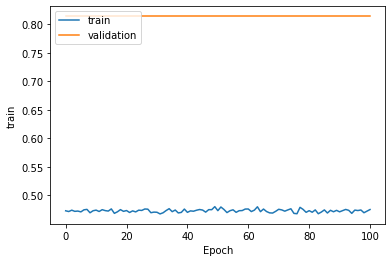

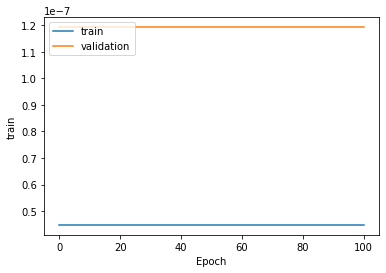

In [98]:
show_train_history(history, 'accuracy', 'val_accuracy')
show_train_history(history, 'loss', 'val_loss')

In [126]:
test = preprocessing.scale(test)
result = model.predict(test)

In [128]:
thresh = result.mean()

for i in range(len(result)):
    if result[i] > thresh:
        result[i] = 1
    else:
        result[i] = 0

In [129]:
result.sum()

1983.0

In [130]:
store_csv(result[:, 0].astype(int), 'ada_DNN.csv')